## Modèle en production

Laurent Cetinsoy - Datadidacte

Une des supposition centrale pour qu'un modèle de machine learning marche est que la distribution des données ne diffère pas de celle des données d'entrainement.

On ne peut garantir la généralisation d'un modèle que si la distribution des données est similaire à celle de la distribution $ X_{prod} \tilde{} \,  P_{train}$

Ainsi, si les données que le modèle voient en production n'ont pas la même distribution (ne ressemblent pas) aux données de train, alors le modèle aura peu de chance de faire de bonne prédictions.

Il est donc important de surveille les données vues par le modèle en production.

Pour cela on va mesurer ce qu'on appelle le Data drift : on va mesurer à quel point les données s'écartent des données de train.

Et on pourra ainsi lever une alerte si c'est le cas.

## Utilisation Eurybia



En consultant la documentation de Eurybia (https://eurybia.readthedocs.io/en/latest/overview.html), expliquer le principe de fonctionnement de Euribya :

- A quoi sert le modèle de classification ?
- A-t-on besoin d’avoir les labels issus de la production pour pouvoir utiliser cette approche ?
- Quel est le critère pour déterminer qu’il y a un data-drift ?


Réponse :

- Le modèle de classificatio binaire sert à prédire si une donnée fait partie du dataset d'entrainement(history) ou de production (current)
- Non
- Il utilise le ROC Area under the curve , si la valeur est proche de 0.5 alors il  y n'a vraisemblalement pas de data un data drift, mais si la valeur se rapproche de 1 alors il y a un data drift

Installer eurybia

In [ ]:
!pip install eurybia

Utiliser eurybia pour monitorer le modèle. Dans un premier temps faire en sorte que les données (df_current) soient de la même distribution que vos données d’entraînement. Vérifier que Eurybia pense que le modèle ne drift pas


In [ ]:
import pandas as pd
df_baseline = pd.read_csv("houses.csv")
df_current = pd.read_csv("houses.csv")
df_current.head(5)

,size,nb_rooms,garden,orientation,price
0,205.999169,2,0,Ouest,260972.164975
1,186.559166,2,0,Ouest,256534.245748
2,187.143785,1,1,Est,282674.291717
3,83.315363,2,1,Est,266555.384156
4,161.781580,2,1,Sud,319158.418695


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(["Nord", "Sud", "Est", "Ouest"])
print(list(le.classes_))
df_baseline["orientation"] = le.transform(df_baseline["orientation"])
df_current["orientation"] = le.transform(df_current["orientation"])

['Est', 'Nord', 'Ouest', 'Sud']


In [ ]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
model = LinearRegression()
X = df_baseline.drop("price", axis=1)
y = df_baseline["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model.fit(X_train, y_train)

LinearRegression()

Faire de même avec des données de test. Les données de tests ont-elle un drift par rapport au train ?


In [ ]:
!pip install jupyter_bokeh

In [ ]:
from eurybia import SmartDrift
sd = SmartDrift(
  df_current=X_test, # ou df_current
  df_baseline=X_train, # ou df_baseline
  deployed_model=None, # Optional: put in perspective result with importance on deployed model
  encoding=None, # Optional: if deployed_model and encoder to use this model
  dataset_names={"df_current": "Current dataset Name", "df_baseline": "Baseline dataset Name"} # Optional: Names for outputs
  )

sd.compile(
  full_validation=True, # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
  date_compile_auc='01/01/2022', # Optional: useful when computing the drift for a time that is not now
  datadrift_file="datadrift_auc.csv", # Optional: name of the csv file that contains the performance history of data drift
  )

sd.generate_report(
  output_file='my_report_name.html',
  title_story="my_report_title",
  title_description="my_report_subtitle", # Optional: add a subtitle to describe report
  )

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7c4f1815eb30>
The computed AUC on the X_test used to build datadrift_classifier is equal to: 0.2857142857142857


Générer des données qui ne ressemblent ni au train ni au test (par exemple avec des données abérentes). Euribya détecte-t-il ces données ?

## Alibaba detect

Dans cette partie on va utiliser la librairie https://github.com/SeldonIO/alibi-detect pour faire la détection de problèmes
Installer la librairie avec pip

In [ ]:
!pip install alibi-detect[tensorflow]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.24.0
    Uninstalling tensorflow-probability-0.24.0:
      Successfully uninstalled tensorflow-probability-0.24.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1


Charger le jeu de donnée cifar10 avec keras et récupérer le train et le test puis,

Normaliser les données de train en faisant un MinMaxScaling (diviser par 255)

In [ ]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train/255
X_test = X_test/255

170498071/170498071 [==============================] - 2s 0us/step


Dans le sous package alibbi_detect.datasets importer les  fonction fetch_cifar10c et corruption_types_cifar10c

In [ ]:
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

Afficher les types de corruption de données disponible avec la fonction corruption_types_cifar10c

In [ ]:
corruption_types_cifar10c()

['brightness',
 'contrast',
 'defocus_blur',
 'elastic_transform',
 'fog',
 'frost',
 'gaussian_blur',
 'gaussian_noise',
 'glass_blur',
 'impulse_noise',
 'jpeg_compression',
 'motion_blur',
 'pixelate',
 'saturate',
 'shot_noise',
 'snow',
 'spatter',
 'speckle_noise',
 'zoom_blur']

Avec la fonction fetch_cifar10c récupérer des exemples corrompus de donnée ressemblant à cifar 10 et les stocker dans des variable X_corrupted et y_corrupted.

Vous choisirez 1 ou 2 corruptions parmis les suivantes : ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']

Vous spécifirez les argument severity=5 et return_X_y=True
attention le dataset peut être lourd si vous utilisez bcp de corruptions

In [ ]:
corruption = ['gaussian_noise']#, 'motion_blur', 'brightness', 'pixelate']
X_corrupted, y_corrupted = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)

Normaliser les images corrompues

In [ ]:
X_corrupted = X_corrupted/255

Afficher plusieurs des images corrompues.

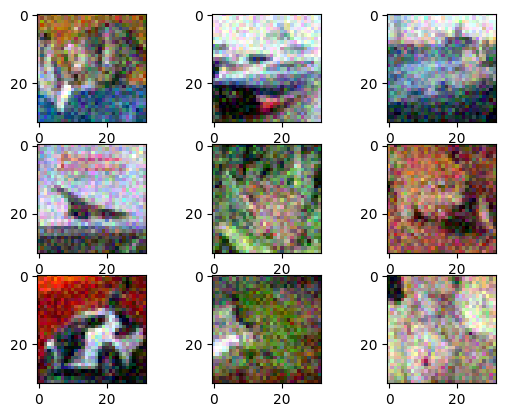

In [ ]:
from matplotlib import pyplot as plt

for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(X_corrupted[i])
plt.show()

On va maintenant prendre un modèle entraîné sur cifar10 pour voir l'impact des performances sur le modèle.

Avec la fonction  fetch_tf_model du module alibi_detect.utils.fetching, charger le modèle préentraîné resnet32 sur cifar10


In [ ]:
from alibi_detect.utils.fetching import fetch_tf_model, fetch_detector
dataset = 'cifar10'
model_name = 'resnet32'
model = fetch_tf_model(dataset, model_name)

4293464/4293464 [==============================] - 0s 0us/step


Calculer la performance du model sur le jeu de train et de test

In [ ]:
print(model.evaluate(X_train))
print(model.evaluate(X_test))

1563/1563 [==============================] - 8s 4ms/step - loss: 0.1250 - sparse_categorical_accuracy: 0.0000e+00
[0.12504078447818756, 0.0]
313/313 [==============================] - 1s 4ms/step - loss: 0.1250 - sparse_categorical_accuracy: 0.0000e+00
[0.12503816187381744, 0.0]


Calculer la performance du modèle sur le jeu de donnée corrompu. Vous devriez observer qu'il chute significativement

In [ ]:
print(model.evaluate(X_corrupted))

313/313 [==============================] - 1s 4ms/step - loss: 0.1250 - sparse_categorical_accuracy: 0.0000e+00
[0.12503816187381744, 0.0]


On va maintenant voir comment détecter les changement de distributions de données.

Pour les données non tabulaire ou à haute dimension on procéde généralement en deux étapes :

1. Faire une réduction de dimension
2. Faire un test permettant de voir si les données projetées ont changé de distribution ou pas

Il existe plusieurs manières de faire de la réduction de dimension. La plus classique est la PCA.

Il est possible également d'utiliser des Auto-encoder

Le code suivant permet de créer la première partie (l'encoder) d'un auto-encoder simple qui nous servira à réduire les dimension des données.

In [ ]:
from functools import partial
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape
from alibi_detect.cd.tensorflow import preprocess_drift
import tensorflow as tf
tf.random.set_seed(0)

# define encoder
encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)

Le drift detector a besoin d'une donnée de référence afin d'effectuer la comparaison avec les données à monitorer.
Créer une variable X_ref avec un échantillon aléatoire des données de test

In [ ]:
X_ref = X_test[0:100]

A quoi sert le test statistique kolmogorov smirnoff ?

Le test statistique de Kolmogorov-Smirnov (aussi appelé test K-S) sert à comparer deux distributions de données. Plus précisément, il permet de déterminer si un échantillon de données suit une certaine loi de probabilité théorique (comme la loi normale, exponentielle, etc.) ou si deux échantillons de données proviennent de la même distribution.

Instancier la classe KSDrift dans une variable nommée **detector**

Il faut lui passer le dataset de reference, une p value (prendre 0.05) et une fonction permettant de faire le preprocessing. On a créé la fonction pour vous


In [ ]:
from alibi_detect.cd.tensorflow import preprocess_drift
preprocess_function = partial(preprocess_drift, model=encoder_net, batch_size=32)

A laide du Drift detector et la méthode predict faire des prediction sur les données de test et sur les données corrompue pour voir si il détecte un changement de distribution

In [ ]:
from alibi_detect.cd import KSDrift

detector = KSDrift(X_ref, p_val=.05, preprocess_fn=preprocess_function)

preds_test = detector.predict(X_test, return_p_val=True)
preds_corrupted = detector.predict(X_corrupted, return_p_val=True)

print("Predictions on test data:", preds_test)
print("Predictions on corrupted data:", preds_corrupted)

Predictions on test data: {'data': {'is_drift': 1, 'distance': array([0.1145, 0.1206, 0.0438, 0.0866, 0.0784, 0.0798, 0.0981, 0.1008,
       0.12  , 0.0748, 0.0656, 0.0537, 0.1055, 0.0595, 0.0467, 0.1019,
       0.1421, 0.1007, 0.0779, 0.0967, 0.0926, 0.1936, 0.0924, 0.1311,
       0.1085, 0.1012, 0.0748, 0.1489, 0.1287, 0.0927, 0.0575, 0.0779],
      dtype=float32), 'p_val': array([0.1378916 , 0.10328154, 0.9870626 , 0.42388985, 0.55036193,
       0.52773064, 0.27797294, 0.2496042 , 0.10633092, 0.60987   ,
       0.76272154, 0.9229249 , 0.20542663, 0.8538718 , 0.97529376,
       0.23868018, 0.03306639, 0.25061533, 0.5585247 , 0.2935642 ,
       0.34272033, 0.00100317, 0.34525132, 0.06062062, 0.1805349 ,
       0.2455898 , 0.60987   , 0.02218124, 0.06874202, 0.34145945,
       0.88002056, 0.5585247 ], dtype=float32), 'threshold': 0.0015625}, 'meta': {'name': 'KSDrift', 'online': False, 'data_type': None, 'version': '0.12.0', 'detector_type': 'drift'}}
Predictions on corrupted data: {'d